In [1]:
#from cityscapes_dataset import CityscapesDataset
from nyuv2_dataset import NYUv2Dataset
from cityscapes_dataset import CityscapesDataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from cross_stitchnet import CrossStitchNet
from densenet import DenseNet
from mtan import MTAN
from segnet import SegNet
from trainer import Trainer
from utils import count_params

from basic_modules import ConvLayer

2025-03-17 23:34:29.563618: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 23:34:29.601783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 23:34:30.280953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset_string = 'cityscapes'
tasks = ['segmentation', 'depth'] if dataset_string == 'cityscapes' else ['segmentation', 'depth', 'normal']
depth_activation = 'sigmoid' if dataset_string == 'cityscapes' else 'relu'
BATCH_SIZE = 8 if dataset_string == 'cityscapes' else 2
LR = 1e-4

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


In [4]:
if dataset_string == 'nyuv2':
    print("NYUv2 Dataset")
    nyuv2_train = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='train')
    classes = nyuv2_train.get_classes()

    nyuv2_val = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='val')
    train_dl = DataLoader(nyuv2_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(nyuv2_val, batch_size=BATCH_SIZE, shuffle=False)

    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)) + ',' + ' Normals: ' + str(list(out['normal'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ',' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        print('Normals: ' + str(out['normal'].max().item()) + ', ' + str(out['normal'].min().item()))
        break
else:
    print("Cityscapes Dataset")
    cityscapes_train = CityscapesDataset(root="../dataset/cityscapes_preprocessed")
    cityscapes_val = CityscapesDataset(root="../dataset/cityscapes_preprocessed", split='val')
    train_dl = DataLoader(cityscapes_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(cityscapes_val, batch_size=BATCH_SIZE, shuffle=False)
    classes = cityscapes_train.get_classes()
    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ', ' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        break

Cityscapes Dataset
Image: [8, 3, 128, 256], Label: [8, 128, 256], Depth: [8, 128, 256]
Image: 1.0, 0.0196078431372549
Label: 6.0, -1.0
Depth: 0.4922102689743042, 0.0


In [5]:
#model = CrossStitchNet(classes=classes, tasks=['segmentation', 'depth', 'normal'], depth_activation='relu').to(device)
model = MTAN(classes=classes, tasks=tasks, depth_activation=depth_activation).to(device)
#model = SegNet(classes=classes).to(device)
print(f"{model.name} has {count_params(model)} parameters")
# opt = torch.optim.Adam(model.parameters(), lr=1e-4)
# trainer = Trainer(model, opt)
# trainer.train(train_dl, val_dl, epochs=2, save=True)

mtan_seg_dep has 42921034 parameters


In [6]:
opt = torch.optim.Adam(model.parameters(), lr=LR)
trainer = Trainer(model, opt, dataset_string, device)

100%|██████████| 372/372 [01:32<00:00,  4.01it/s]


Epoch 1/5 - train total loss: 0.9898
train loss segmentation: 0.9011
train loss depth: 0.0887
miou: 0.1801619976758957
pix_acc: 0.7412762641906738
mae: 0.08875232934951782
mre: 160.79098510742188
gradient norm: 0.9477



100%|██████████| 63/63 [00:05<00:00, 12.48it/s]


val loss segmentation: 0.5490
val loss depth: 0.0416
val loss total: 0.5906
miou: 0.2540
pix_acc: 0.8555
mae: 0.0415
mre: 72.4714




100%|██████████| 372/372 [01:33<00:00,  4.00it/s]


Epoch 2/5 - train total loss: 0.4942
train loss segmentation: 0.4566
train loss depth: 0.0376
miou: 0.2847658693790436
pix_acc: 0.8751223683357239
mae: 0.03762888163328171
mre: 44.06653594970703
gradient norm: 1.7802



100%|██████████| 63/63 [00:05<00:00, 12.49it/s]


val loss segmentation: 0.4295
val loss depth: 0.0332
val loss total: 0.4628
miou: 0.2917
pix_acc: 0.8864
mae: 0.0332
mre: 52.3897




100%|██████████| 372/372 [01:32<00:00,  4.00it/s]


Epoch 3/5 - train total loss: 0.4145
train loss segmentation: 0.3834
train loss depth: 0.0310
miou: 0.3086411654949188
pix_acc: 0.8929249048233032
mae: 0.031008165329694748
mre: 37.28446578979492
gradient norm: 1.7914



100%|██████████| 63/63 [00:05<00:00, 12.57it/s]


val loss segmentation: 0.3842
val loss depth: 0.0288
val loss total: 0.4130
miou: 0.3022
pix_acc: 0.8946
mae: 0.0287
mre: 50.0781




100%|██████████| 372/372 [01:32<00:00,  4.01it/s]


Epoch 4/5 - train total loss: 0.3694
train loss segmentation: 0.3428
train loss depth: 0.0266
miou: 0.3230739235877991
pix_acc: 0.901946485042572
mae: 0.026619620621204376
mre: 35.291297912597656
gradient norm: 0.7098



100%|██████████| 63/63 [00:05<00:00, 12.49it/s]


val loss segmentation: 0.3682
val loss depth: 0.0252
val loss total: 0.3934
miou: 0.3167
pix_acc: 0.8964
mae: 0.0251
mre: 49.9263




100%|██████████| 372/372 [01:33<00:00,  4.00it/s]


Epoch 5/5 - train total loss: 0.3377
train loss segmentation: 0.3142
train loss depth: 0.0235
miou: 0.34025463461875916
pix_acc: 0.9090531468391418
mae: 0.023484278470277786
mre: 34.740135192871094
gradient norm: 1.4099



100%|██████████| 63/63 [00:05<00:00, 12.53it/s]


val loss segmentation: 0.3520
val loss depth: 0.0230
val loss total: 0.3749
miou: 0.3184
pix_acc: 0.9009
mae: 0.0229
mre: 47.8736




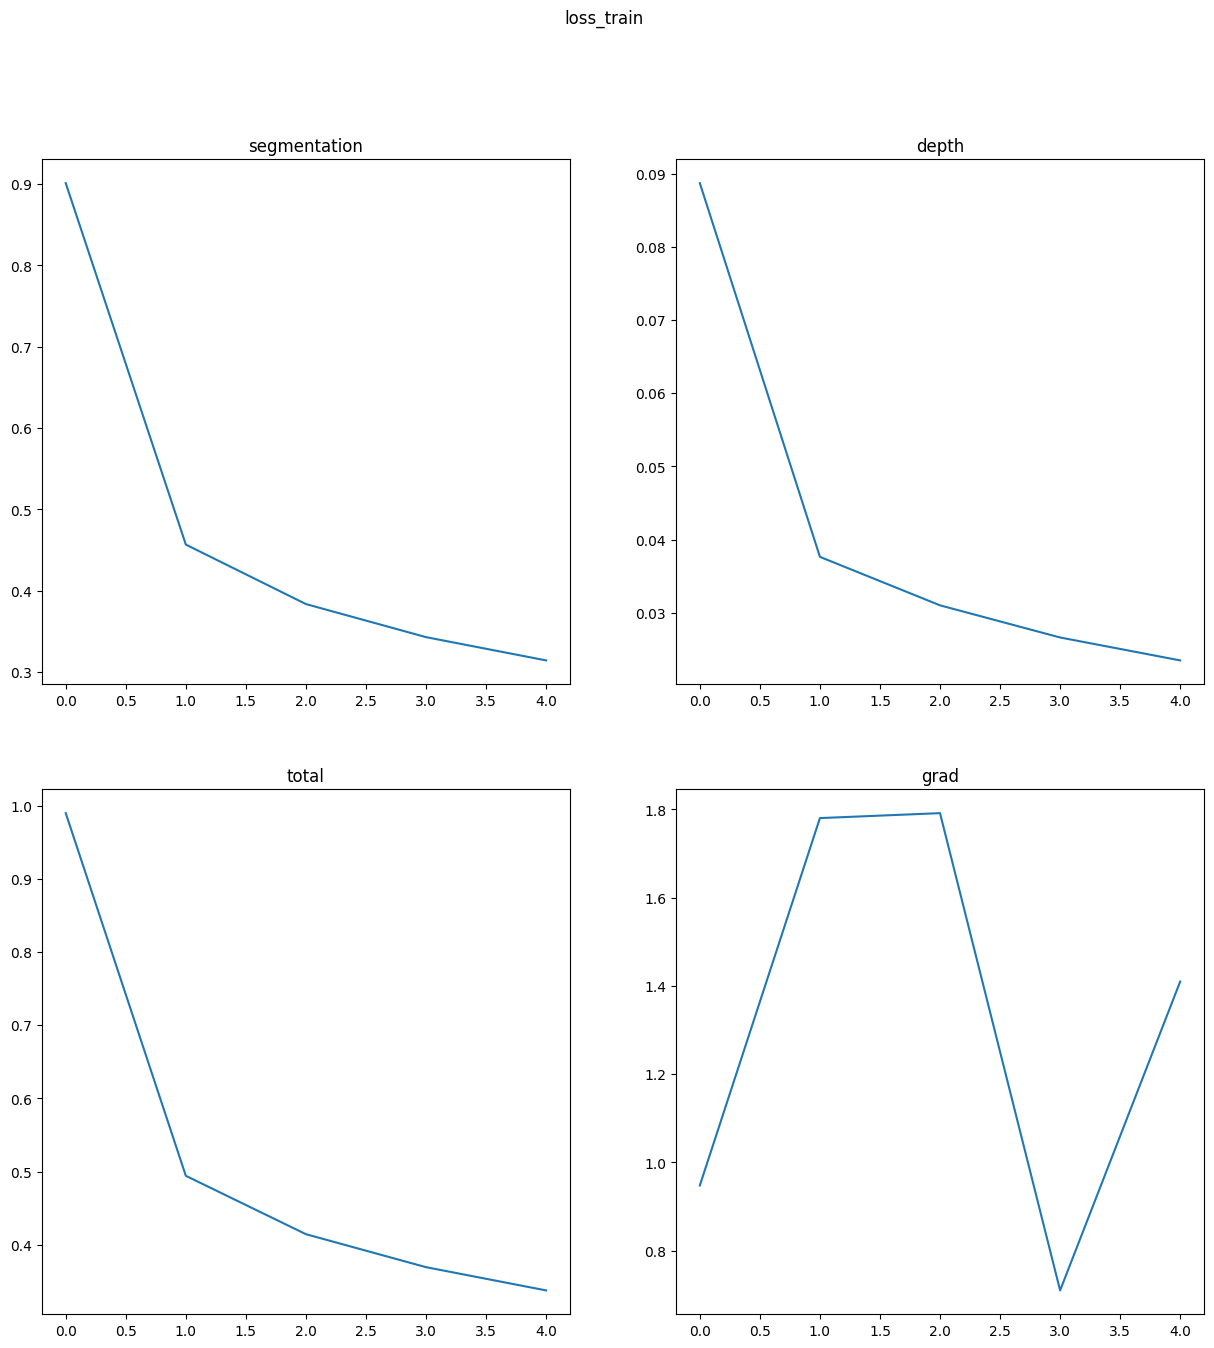

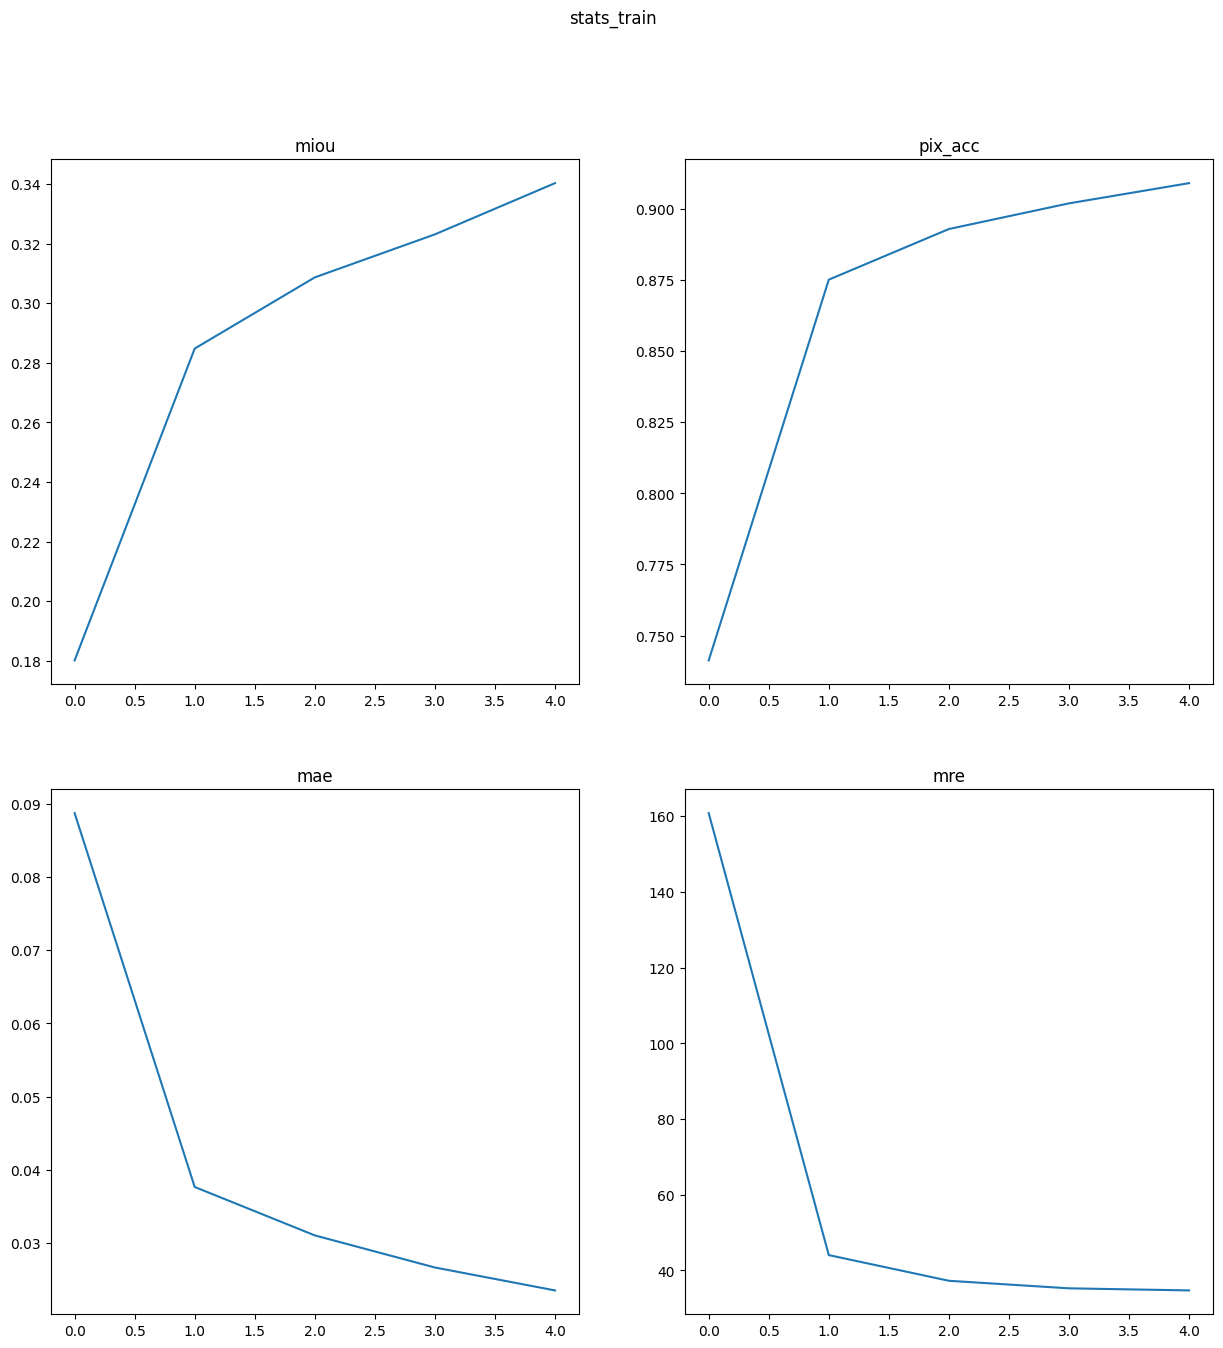

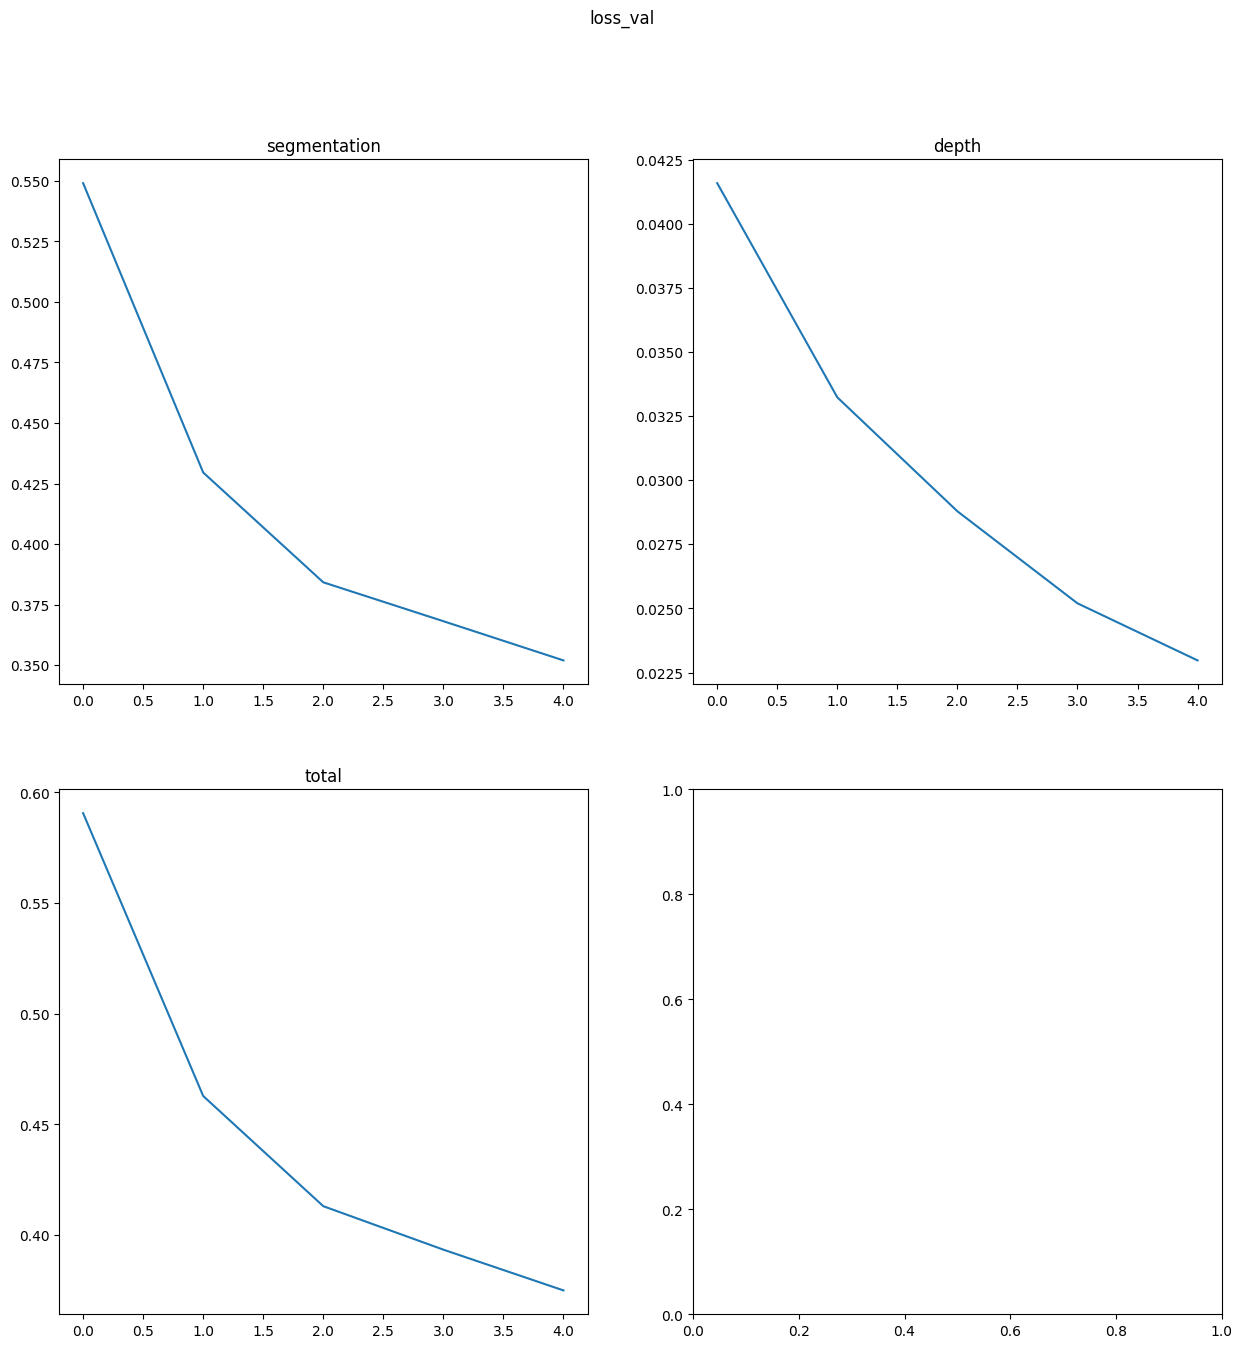

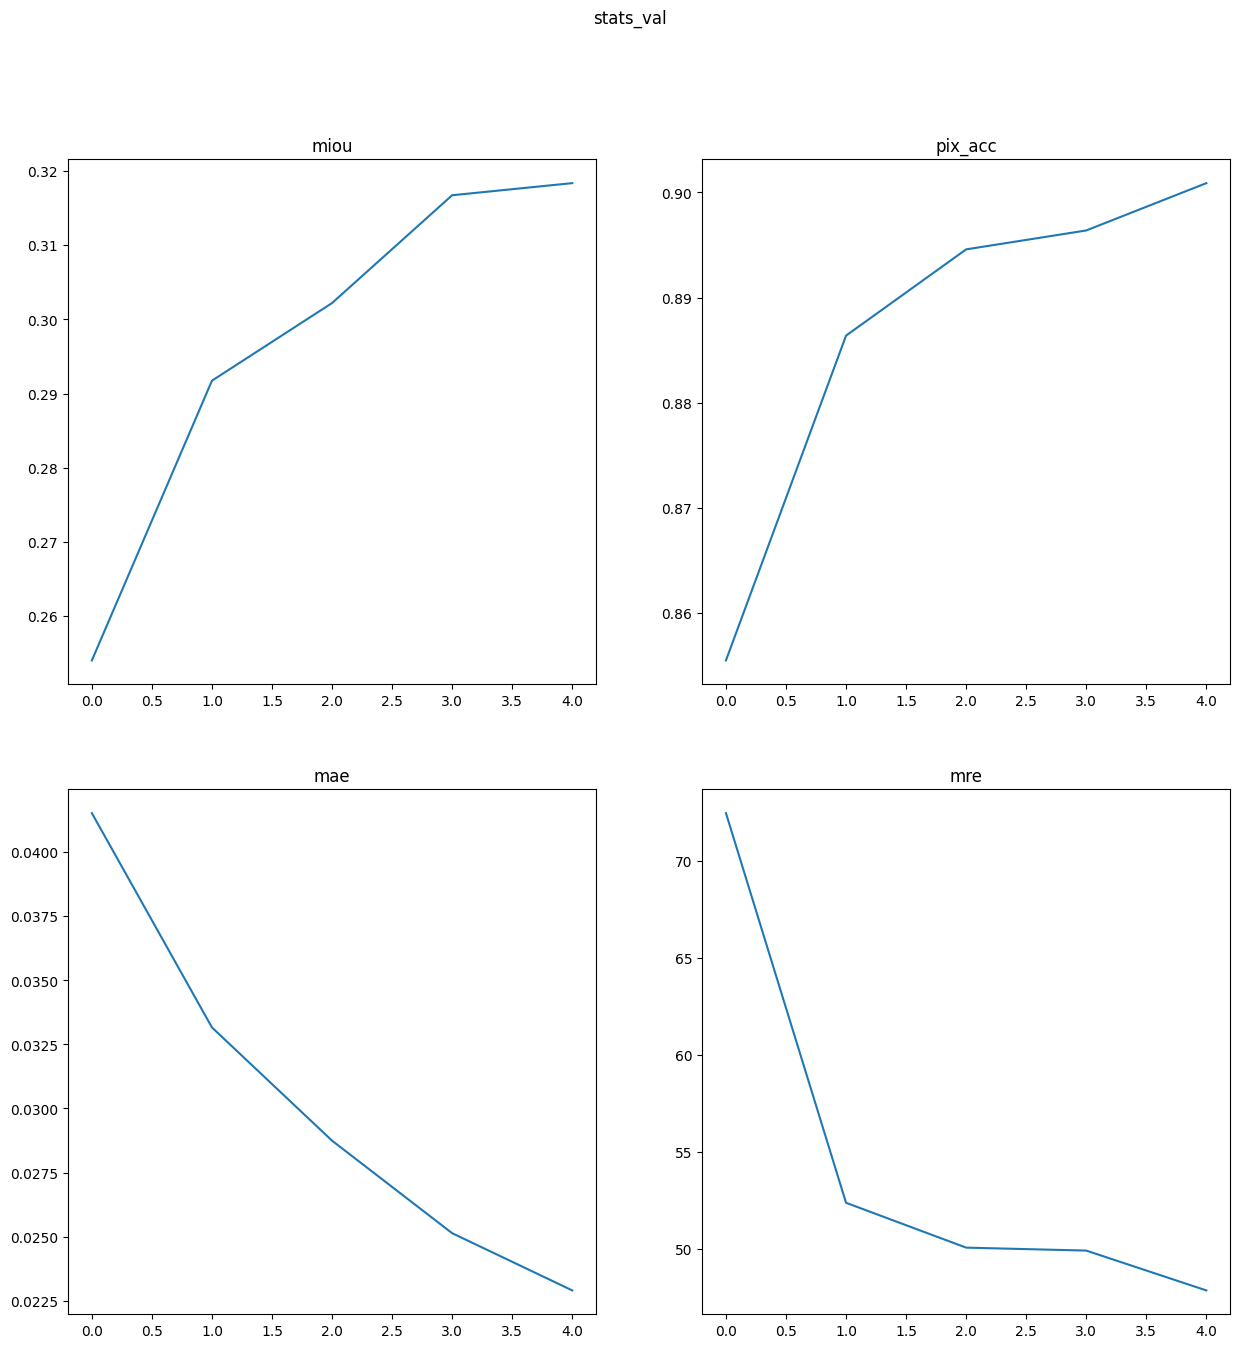

In [7]:
trainer.train(train_dl, val_dl, epochs=5, save=True, check=1, grad=True)

In [8]:
# for x, y in train_dl:
#     x = x.to(device).to(torch.float)
#     y = {k: v.to(device) for k, v in y.items()}
#     y['segmentation'] = y['segmentation'].to(torch.long)
#     y['depth'] = y['depth'].to(torch.float)
#     out = model(x)
#     print(f"Segmentation: {out['segmentation'].shape}")
#     print(f"Depth: {out['depth'].shape}")
#     print(f"Normals: {out['normal'].shape}")
#     break

In [9]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# tests = 10
# path = 'models/mtan/mtan_train10.pth'
# model = MTAN(classes=LABELS)
# model.load_state_dict(torch.load(path, weights_only=True))
# model.to(device)
# for i, (img, img_seg, img_depth) in enumerate(val_dl):
#     visualize_results_multitask(model, img[0], img_seg[0], img_depth[0], device)
#     if i == tests:
#         break